# Project 2 - Prediciting Release Year of Songs on Spotify

### By: Sam Busane & Andrew Cline

## Introduction

From Kaggle we have a data set that holds the catalog of songs from the music streamin app Spotify. The list of songs has some that date back to the 1940's. The data set also holds information about each song such as dancibility, tempo, acousticness, and popularity as well as others. Using these traits we want to build a model that can accurately predict a the decade in which a song was released. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import export_graphviz
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
df = pd.read_csv('data.csv')

## Initial Exploration

This dataset is quite large since it encompasses whole of Spotify's song library. Since the goal is to predict the year a song came out it is important to look for variables that would intuitively be tied to changes over time.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

Looking at the dataframe info it shows that almost all of the data in this dataset is numeric, save for explicit, release date, name, artists, and id. Some of the columns are not relevant to the predictions that are going to be made, so they will be removed later.

In [4]:
df.isna().sum()

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64

Since this dataset was obtained from Kaggle the expectation is that it would be very clean and this dataset is no exception. There are no NA value, so there is no cleaning needed.

## Preprocessing

The dataset contains some values that would not help develop a model. These values would be artists, id, name, and release_date since they are purely identifying features of a song and would be unhelpful for developing a model. So they should be removed from the dataset. 

In [5]:
df.drop(['id', 'release_date', 'name', 'artists'], axis=1, inplace=True)

Recorded music is a relatively new advent and it was not widely popular until a few decades after its release. So there may be skewed data the farther back in time that the data goes. To make visualization easier the songs will be binned together by decade and added to a new column.

In [6]:
df['decade'] = pd.cut(df['year'], bins=[1920,1929,1939,1949,1959,1969,1979,1989,1999,2009,2029], labels=['20s', '30s','40s',
                                                                                                        '50s','60s','70s',
                                                                                                        '80s', '90s', '2000s',
                                                                                                        '2010s'])

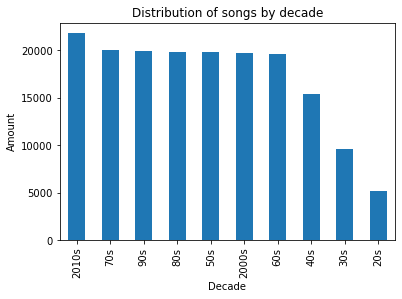

In [7]:
df['decade'].value_counts().plot.bar()
plt.title('Distribution of songs by decade')
plt.xlabel('Decade')
plt.ylabel('Amount');

So there is clearly an under representation of the data before 1950. So it would be good for developing the model if those data poins were dropped so that they do not skew the model.

In [8]:
df = df[df['year'] >= 1950]
df['decade'] = pd.cut(df['year'], bins=[1949,1959,1969,1979,1989,1999,2009,2029], labels=['50s','60s','70s',
                                                                                          '80s', '90s', '2000s',
                                                                                          '2010s'])

## Visualization 

When developing the model strongly correlated values should be avoided because the correlation may be overrepresented in the model and skew the predictions.

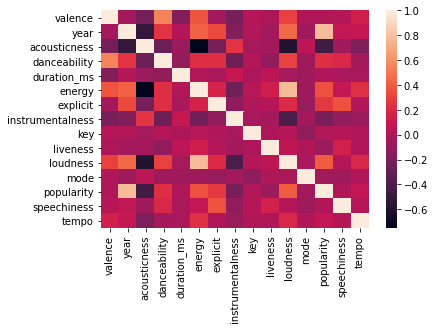

In [9]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Acousticness is very strongly correlated to a lot of values. It would be imparative to include it in the final model because it represents so much in terms of correlation.

Since most people group music by decade it would useful to see changes over the decades in the various numeric values of the dataset.

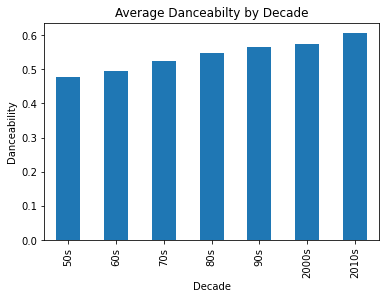

In [10]:
df.groupby('decade')['danceability'].mean().plot.bar()
plt.title('Average Danceabilty by Decade')
plt.xlabel('Decade')
plt.ylabel('Danceability');

The graph shows that there is a small trend of danceability increasing with time. Due to this value having a clear change over time it would be good to include in the model as a predictor.

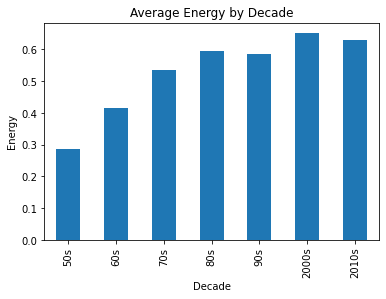

In [11]:
df.groupby('decade')['energy'].mean().plot.bar()
plt.title('Average Energy by Decade')
plt.xlabel('Decade')
plt.ylabel('Energy');

An odd trend is shown by this graph. Over time there is an increase in energy until the 80s then the value again stagnates like acousticness. Energy represents how fast, loud, and noisy the song is, this trend could be due to the proliferation and development of rock over time. As rock progressed it generally got more and more fast and noisy. Another value to consider for the model.

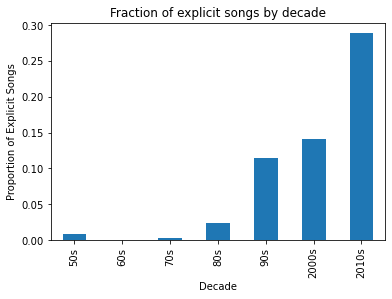

In [12]:
tbl = df.groupby('decade')['explicit'].apply(lambda x: (x == 1).mean())
tbl.plot.bar()
plt.title('Fraction of explicit songs by decade')
plt.xlabel('Decade')
plt.ylabel('Proportion of Explicit Songs');

The graph showcases another intuitive trend. The trend of music getting more explicit also coincides with the rise of rap, which tends to be more explicit than other genre. This could a helpful predictor since it again changes over time.

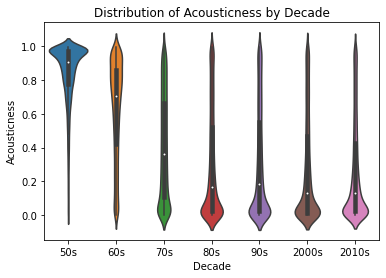

In [13]:
sns.violinplot(x='decade', y='acousticness', data=df)
plt.title('Distribution of Acousticness by Decade')
plt.xlabel('Decade')
plt.ylabel('Acousticness');

This graph makes sense intuitvively since electronically produced music is a relatively newer type of music, but the graph does show a kind of stagnation of acousticness from the 80s to the 2010s. But since this value is tightly related to other values it should be included in the model.

## Building the Model

In [14]:
predictors = ['valence', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 
              'speechiness', 'popularity', 'liveness', 'loudness', 'mode', 'tempo']
X = df[predictors].values
y = df['year'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140600 entries, 5606 to 170652
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   valence           140600 non-null  float64 
 1   year              140600 non-null  int64   
 2   acousticness      140600 non-null  float64 
 3   danceability      140600 non-null  float64 
 4   duration_ms       140600 non-null  int64   
 5   energy            140600 non-null  float64 
 6   explicit          140600 non-null  int64   
 7   instrumentalness  140600 non-null  float64 
 8   key               140600 non-null  int64   
 9   liveness          140600 non-null  float64 
 10  loudness          140600 non-null  float64 
 11  mode              140600 non-null  int64   
 12  popularity        140600 non-null  int64   
 13  speechiness       140600 non-null  float64 
 14  tempo             140600 non-null  float64 
 15  decade            140600 non-null  category
dtyp

## The Models 

### Decision Tree Regressor

In [16]:
treereg = DecisionTreeRegressor(max_depth=3)
treereg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [17]:
y_predict = treereg.predict(X_test)
errors = y_test - y_predict
rmse = np.sqrt(errors**2).mean()

In [18]:
scores = -cross_val_score(treereg, X, y, scoring='neg_mean_squared_error', cv=10)

scores.mean()
rmse = np.sqrt(scores.mean()).mean()
print(rmse)

13.425577349379202


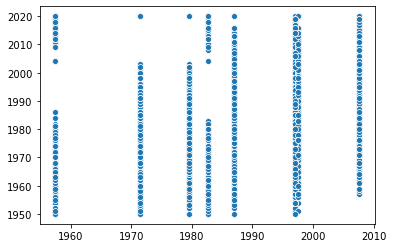

In [19]:
sns.scatterplot(x=y_predict, y=y_test)

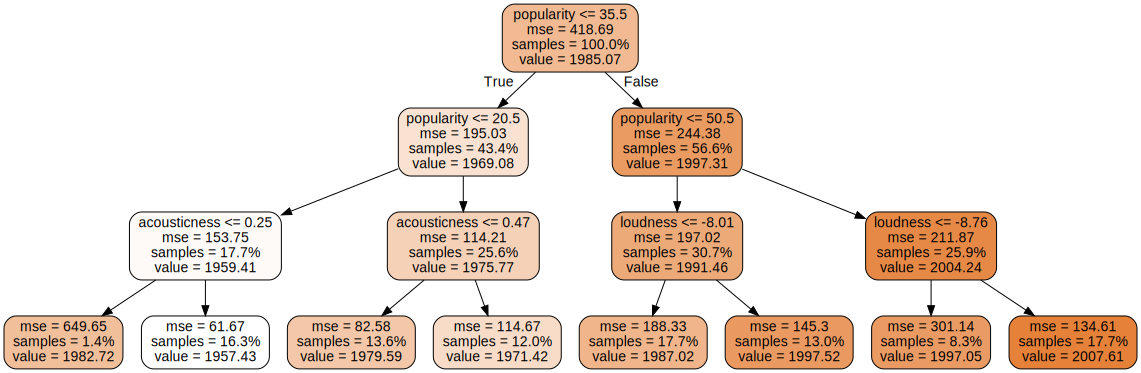

In [20]:
dot_data= export_graphviz(treereg, precision=2,feature_names=predictors,  proportion=True,filled=True, rounded=True) 

graph = graphviz.Source(dot_data)
graph

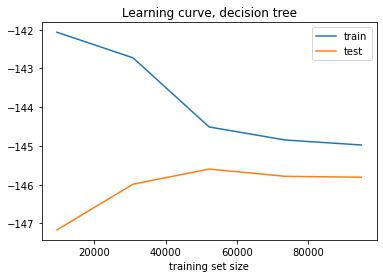

In [21]:
train_sizes, train_scores, test_scores = learning_curve(treereg, X_train, y_train, cv=10, 
                                                         scoring='neg_mean_squared_error')
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.xlabel('training set size')
plt.title('Learning curve, decision tree')
plt.legend();

In [22]:
treereg = DecisionTreeRegressor(max_depth=5)
treereg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [23]:
y_predict = treereg.predict(X_test)
scores = -cross_val_score(treereg, X, y, scoring='neg_mean_squared_error', cv=10)

scores.mean()
rmse = np.sqrt(scores.mean()).mean()
print(rmse)

12.395026521417872


In [24]:
print('RMSE: {:.2f}'.format(rmse))

RMSE: 12.40


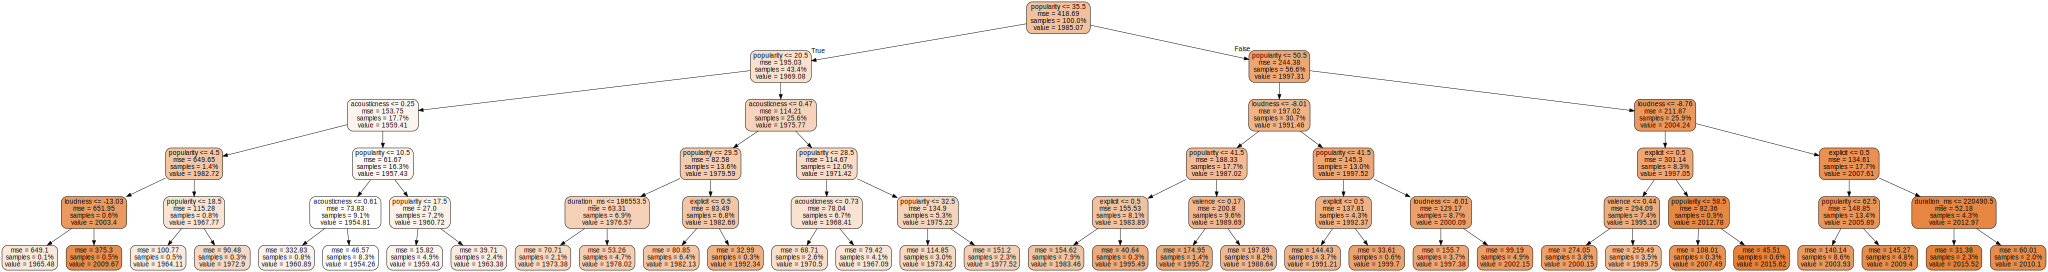

In [25]:
dot_data= export_graphviz(treereg, precision=2,feature_names=predictors,  proportion=True,filled=True, rounded=True) 

graph = graphviz.Source(dot_data)
graph

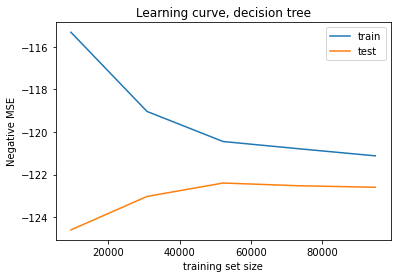

In [26]:
train_sizes, train_scores, test_scores = learning_curve(treereg, X_train, y_train, cv=10, 
                                                         scoring='neg_mean_squared_error')
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.ylabel('Negative MSE')
plt.xlabel('training set size')
plt.title('Learning curve, decision tree')
plt.legend();

### Linear Regression

In [27]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_predict = linreg.predict(X_test)

In [28]:
def forward_feature_selection_lr(X_train,y_train):
    remaining = list(range(X_train.shape[1]))
    selected = []
    n = 10
    while len(selected) < n:
        rmse_min = 1e7
        for i in remaining:
            X_i = X_train[:,selected+[i]]
            scores = cross_val_score(LinearRegression(), X_i, y_train, scoring='neg_mean_squared_error', cv=10)
            rmse = np.sqrt(-scores.mean())
            if rmse < rmse_min:
                rmse_min = rmse
                i_min = i
       	 
        remaining.remove(i_min)
        selected.append(i_min)
        print('num features: {}; rmse: {:.2f}'.format(len(selected), rmse_min))
    return selected

In [29]:
best_array=forward_feature_selection_lr(X_train,y_train)

num features: 1; rmse: 12.78
num features: 2; rmse: 12.24
num features: 3; rmse: 12.04
num features: 4; rmse: 11.89
num features: 5; rmse: 11.75
num features: 6; rmse: 11.62
num features: 7; rmse: 11.58
num features: 8; rmse: 11.56
num features: 9; rmse: 11.55
num features: 10; rmse: 11.54


In [30]:
feature_names=[]
for i in best_array:
    feature_names.append(predictors[i])
feature_names

['popularity',
 'acousticness',
 'explicit',
 'valence',
 'loudness',
 'danceability',
 'instrumentalness',
 'energy',
 'tempo',
 'speechiness']

<p>
In the case for the Linear Regression model the ten best predictors are Popularity, Acousticness, Valence, Danceablility, Energy, Explicit, Loudness, Instrumentalness, Tempo,and Speechiness.</p>

In [31]:
scores = -cross_val_score(linreg, X, y, scoring='neg_mean_squared_error', cv=10)

scores.mean()
rmse = np.sqrt(scores.mean()).mean()
print(rmse)

12.357359182119765


<p>As we can see we get a lower RMSE than the decision tree when we use forward feature selection to find the ten best predictors for the model.</p>

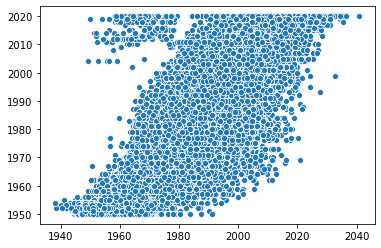

In [32]:
sns.scatterplot(x=y_predict, y=y_test)

In [33]:
y_predict.max()

2040.9311182854026

### KNN Regressor - BAD

In [34]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=3)

In [35]:
y_predict = knn.predict(X_test)
errors = y_test - y_predict
rmse = np.sqrt(errors**2).mean()

In [36]:
print('RMSE: {:.2f}'.format(rmse))

RMSE: 12.65


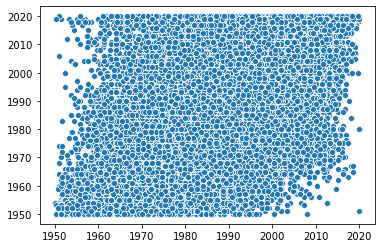

In [37]:
sns.scatterplot(x=y_predict, y=y_test)

In [38]:
param_grid = {'n_neighbors': np.arange(1, 10)}
knn_grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)

In [ ]:
knn_grid.fit(X_train,y_train)

In [ ]:
knn_grid.best_params_

<h4>Buidling the Model with the Best Parameters</h4>

In [ ]:
knn2=KNeighborsRegressor(n_neighbors=5)
knn2.fit(X_train,y_train)

In [ ]:
y_predict2 = knn2.predict(X_test)
errors2 = y_test - y_predict2
rmse2 = np.sqrt(errors2**2).mean()

In [ ]:
print('RMSE: {:.2f}'.format(rmse2))

<p>Using the grid search we come to the conclusion that the ideal number of neighbors is 5 for this model.</p>

### Clustering Analysis

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
centers = kmeans.cluster_centers_
counts = np.bincount(kmeans.labels_)
n = len(predictors)

fix, ax = plt.subplots(k, 1, figsize=(13,8))
for i, axi in enumerate(ax.flat):
    axi.bar(range(n), centers[i,:])
    axi.set_title('number in cluster: {}'.format(counts[i]))
    axi.set_ylim(-3.5, 3.5)
    axi.set_xticks(range(n))
    axi.set_xticklabels(df.columns[:n])
plt.tight_layout()


<p>Looking at these clusters it is hard to decern what they are clustered around.</p>

In [ ]:
prep = ['valence', 'acousticness', 'danceability']



Z = linkage(df[prep], method='complete')

dendrogram(Z)

In [ ]:
df.info()

### Conclusion

<p>After trying out three different machine learning, we can conclude that in terms predicting the decade in which a song was released, linear regresssion yielded the closest predictions. After applying feature selection to the models, linear regression yielded the lowest Root Mean Square Error. Using Popularity, Acousticness, Valence, Danceablility, Energy, Explicit, Loudness, Instrumentalness, Tempo, and Speechiness as the predictors. Looking at the cluster analysis we can see with the three clusters vary greatly in size. The largest being 108966 and the smallest being 671. Looking to at the distance from the center for each attribute we can see that most are grouped close to the center but in the Danceability, Key, Loudness, Popularity areas deviated the most from the cluster center.  </p>